## Shampoo Time Series

In [4]:
# import library
import pandas as pd
from pandas import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# statsmodels seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

#### Time Series Raw

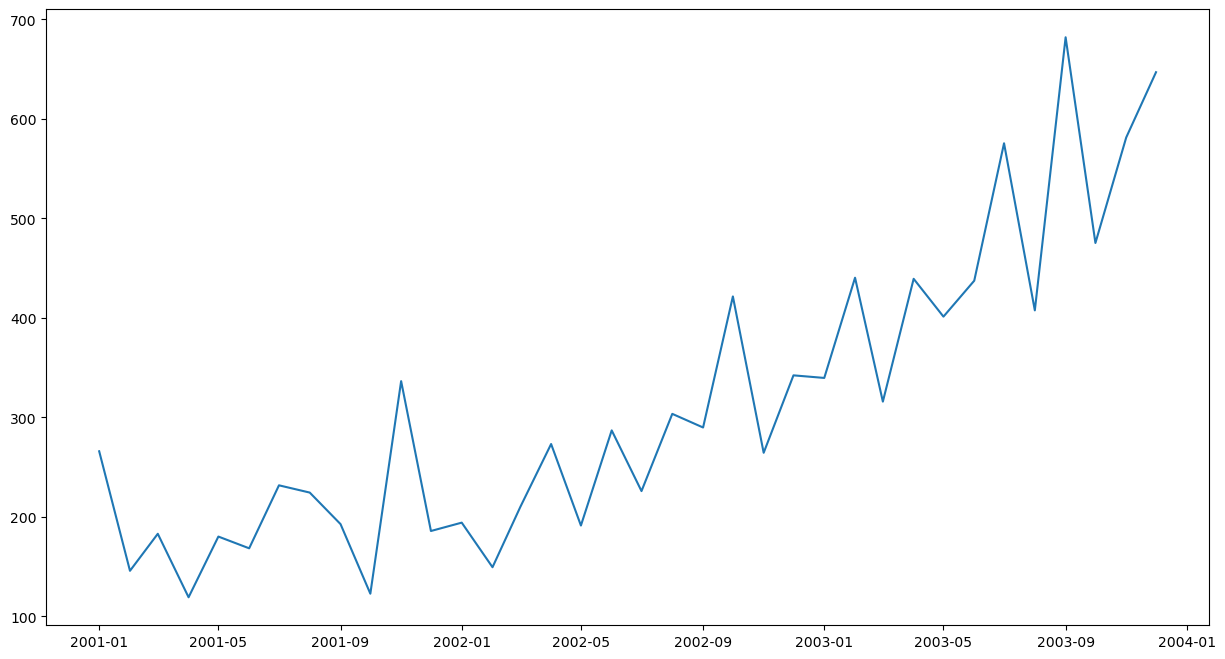

In [3]:
# import shampoo datasets

def parser(x):
    return datetime.strptime('200'+x, '%Y-%m')

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
df = pd.read_csv(url,header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# plot the shampoo dataset grapgh
plt.figure(figsize = (15,8))
plt.plot(df)

In [14]:
# Augmented Dickey-Fuller Test 
# AIC : Akaike's Information Criteria

from statsmodels.tsa.stattools import adfuller

adftest = adfuller(df['Sales'].dropna(), autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -0.7982228272214191
P-Value: 0.9658319472800337
Number of lags: 10
Number of observations: 25
Critical Values: {'1%': -4.3749647199999995, '5%': -3.6034675359999997, '10%': -3.23818632}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


#### First Order Differencing

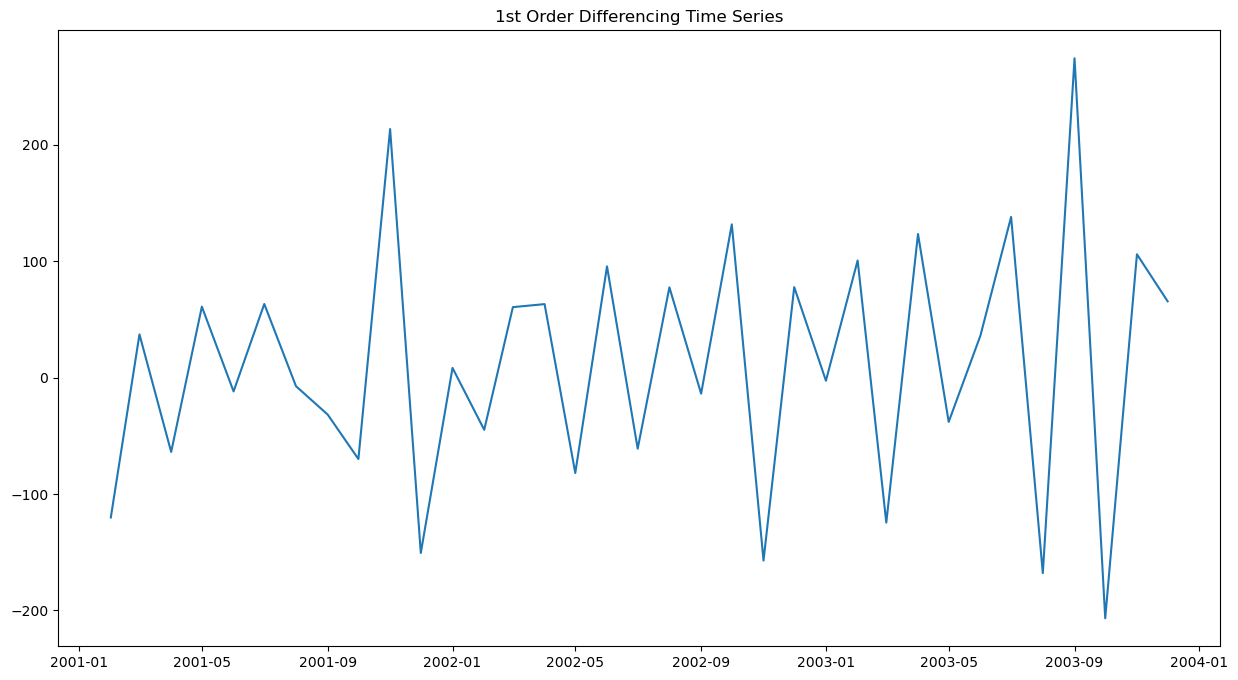

In [9]:
# diferencing method
# differencing for 1 period

df = pd.DataFrame(df)
df['df_first_order_diff'] = df['Sales'].diff()

# plot the dataset graph

plt.figure(figsize = (15,8))
plt.title('1st Order Differencing Time Series')
plt.plot(df['df_first_order_diff'] )

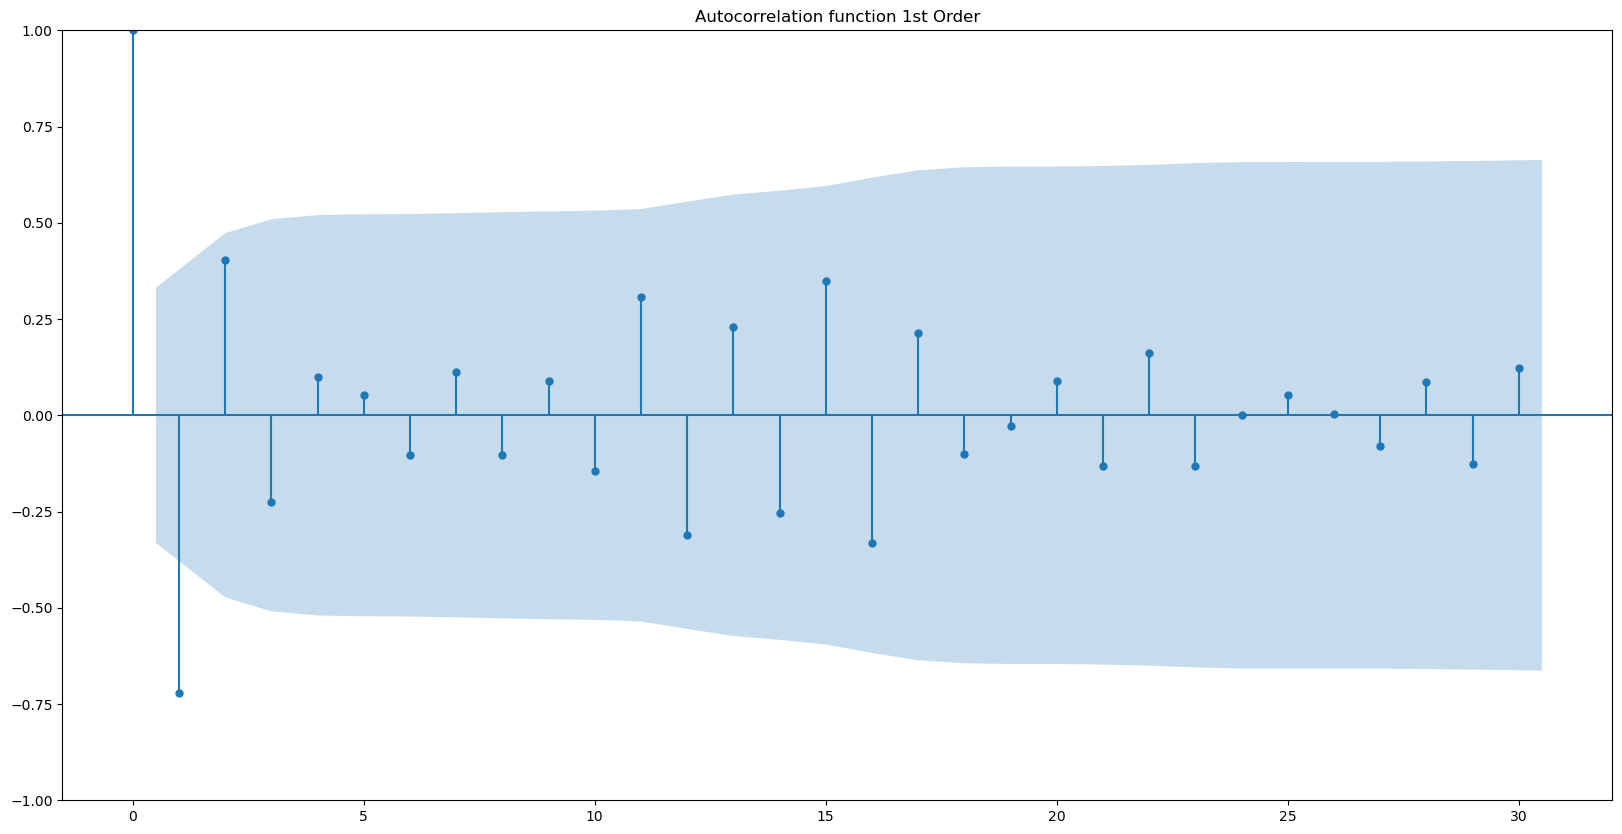

In [12]:
# statsmodels Time series Analysis plot: Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(20,10))
plot_acf(df['df_first_order_diff'].dropna(), lags = 30, title='Autocorrelation function 1st Order')
plt.show()
#data: your time series
#lags: number of 'periods' you will like to investigate 

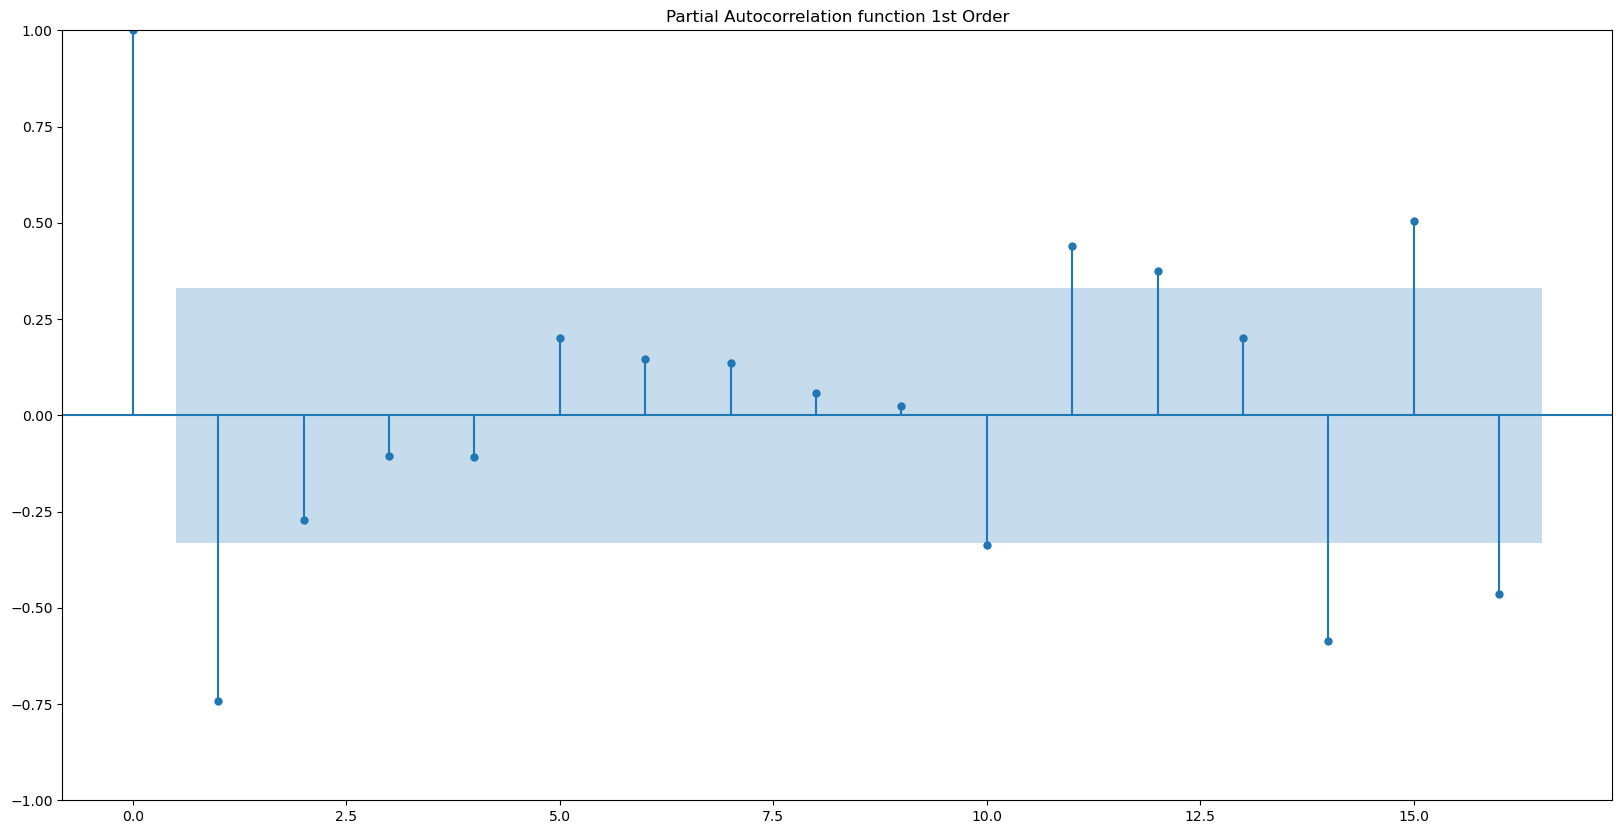

In [15]:
# statsmodels Time series Analysis plot: Partial Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf

plt.rc("figure", figsize=(20,10))
plot_pacf(df['df_first_order_diff'].dropna(), title='Partial Autocorrelation function 1st Order')
plt.show() 

In [13]:
# Augmented Dickey-Fuller Test 
# AIC : Akaike's Information Criteria

from statsmodels.tsa.stattools import adfuller

adftest = adfuller(df['df_first_order_diff'].dropna(), autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest[0])
print("P-Value:", adftest[1])
print("Number of lags:", adftest[2])
print("Number of observations:", adftest[3])
print("Critical Values:", adftest[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -5.351788784082682
P-Value: 4.491563929382048e-05
Number of lags: 10
Number of observations: 24
Critical Values: {'1%': -4.395041166087963, '5%': -3.6123930960648147, '10%': -3.243216493055556}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


#### Observations 

< Differencing >
- As we see above, after the 1st order differencing, the p-value drops beyond the acceptable threshold. 
- Thus, we can consider the order of differencing (“d”) as 1. This corresponds well with the autocorrelation line graph seen above. 

< Autoregression and Moving Average>

- In PACF plot, we see the 5th lag is the most significant. Thus, we consider “p” to be 5.
- Finally, “q” can be estimated similarly by looking at the ACF plot instead of the PACF plot. Looking at the number of lags crossing the threshold, we can determine how much of the past would be significant enough to consider for the future. The ones with high correlation contribute more and would be enough to predict future values.

In [32]:
# import ARIMA

from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(df['Sales'], order=(5,2,2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -191.901
Date:                Mon, 18 Mar 2024   AIC                            399.801
Time:                        23:56:46   BIC                            412.012
Sample:                    01-01-2001   HQIC                           403.966
                         - 12-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2741      3.066     -0.416      0.678      -7.283       4.735
ar.L2         -0.9934      3.912     -0.254      0.800      -8.661       6.674
ar.L3         -0.8128      2.923     -0.278      0.7

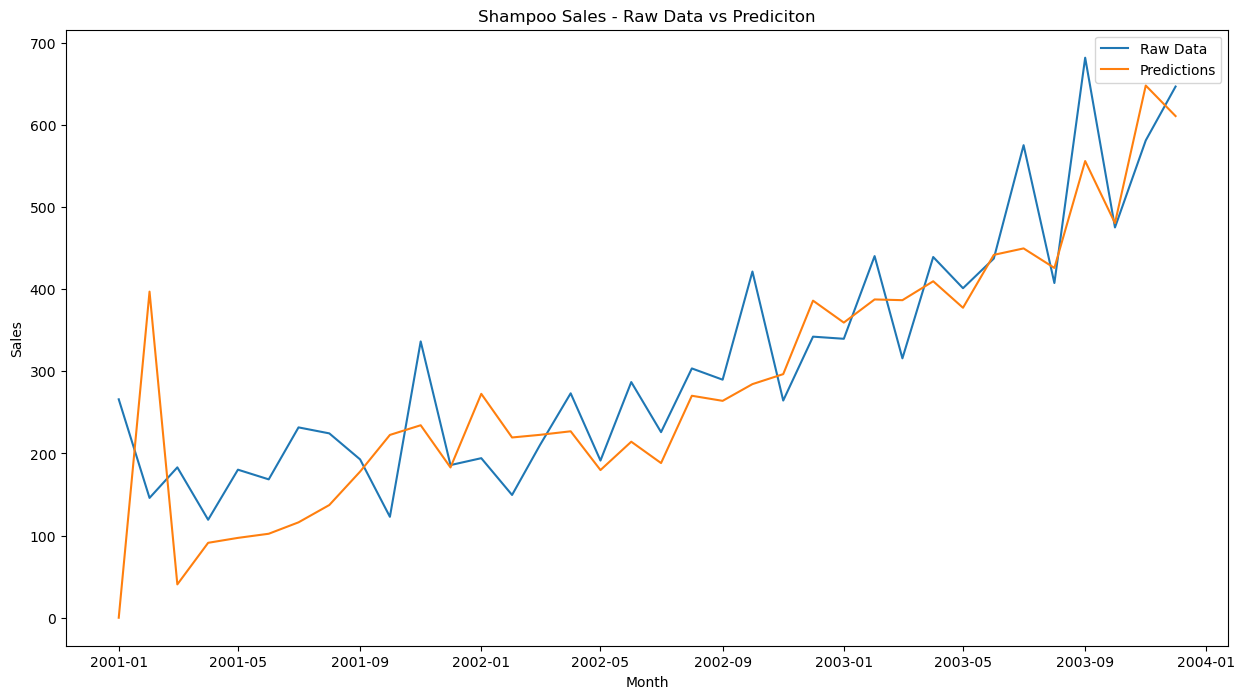

In [37]:
# plot prediction

prediction = model.predict()
plt.figure(figsize = (15,8))
plt.plot(df['Sales'], label = 'Raw Data')
plt.plot(prediction, label = 'Predictions')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Shampoo Sales - Raw Data vs Prediciton')
plt.legend()
plt.show()

#### Search best parameters for ARIMA

In [39]:
pip install arm-mango

Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
df = pd.read_csv(url,header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
df = pd.DataFrame(df)

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit()
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 30),
                   d= range(0, 30),
                   q =range(0, 30),
                   trend = ['n', 'c', 't', 'ct']
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = list(df['Sales'])
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/200 [00:00<?, ?it/s]

best parameters: {'d': 0, 'p': 17, 'q': 14, 'trend': 'ct'}
best loss: 2514.540875730687


In [43]:
# import ARIMA

from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(df['Sales'], order=(17,0,14))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:               ARIMA(17, 0, 14)   Log Likelihood                -211.080
Date:                Tue, 19 Mar 2024   AIC                            488.160
Time:                        00:30:06   BIC                            540.416
Sample:                    01-01-2001   HQIC                           506.399
                         - 12-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        312.7462   2761.690      0.113      0.910   -5100.066    5725.558
ar.L1         -0.8166   1.57e+04  -5.21e-05      1.000   -3.07e+04    3.07e+04
ar.L2         -0.3845   5418.933   -7.1e-05      1.0

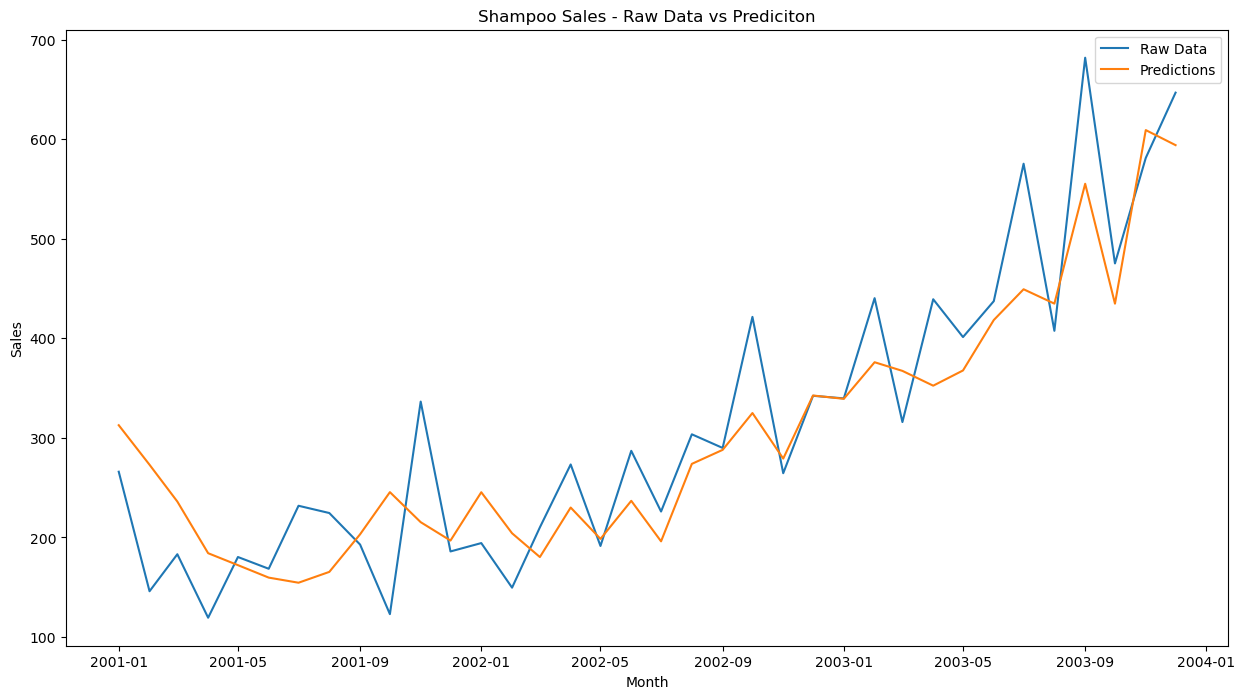

In [44]:
# plot prediction

prediction = model.predict()
plt.figure(figsize = (15,8))
plt.plot(df['Sales'], label = 'Raw Data')
plt.plot(prediction, label = 'Predictions')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Shampoo Sales - Raw Data vs Prediciton')
plt.legend()
plt.show()